# Figures and Tables for Welfare Analysis

This notebook reproduces Table 10 and 11 of the Paper, the welfare effects of a price difference, as well as Figures found in Appendix F (F.1). 

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
from importlib import reload
import pandas as pd
import pickle
from scipy.interpolate import interp1d
from scipy.optimize import bisect
from functools import partial
from itertools import product

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from model import micro, macro, params 
from model import distributions as dist


## Simulation Results

In [3]:
aggs = pd.read_pickle('output/table_10-11_aggregates.pkl')
scenarios = aggs.columns
aggs

,pus_ge,peu_ge,peu_pe,aeu_ge,aeu_pe
m,0.557813,0.594078,0.580346,0.538612,0.539985
y,4.229094,4.270291,4.270291,3.687379,4.270291
c,2.297478,2.458274,2.317035,1.988302,2.003603
k,27.199406,27.895348,27.221799,23.68989,23.902514
n,1.327392,1.327392,1.327392,1.327392,1.327392
s,0.131899,0.104429,0.102976,0.146069,0.109549
csy,0.675154,0.680098,0.650683,0.685288,0.651058
ksy,6.431497,6.532423,6.374694,6.424588,5.597397
h,0.899511,0.92392,0.920364,0.875535,0.877631
g2,1.147230,1.120584,1.123534,1.171403,1.168196


In [4]:
eqs_temp = []
opt_temp = []

In [5]:
scenarios = ['pus_ge','peu_ge','peu_pe','aeu_ge','aeu_pe']

for scn in scenarios:
    file = open('output/eq_'+scn+'3.pkl','rb')
    eq = pickle.load(file)
    file.close()
    eqs_temp.append(eq)
    opt = pd.read_pickle('output/opt_'+scn+'3.pkl')
    opt_temp.append(opt)

In [6]:
eqs  = dict(zip(scenarios,eqs_temp))
opts = dict(zip(scenarios,opt_temp))

## Computing WTP

In [7]:
gridk = eqs['pus_ge'].stats.gridk
ne, nk, nh = eqs['pus_ge'].stats.ne, eqs['pus_ge'].stats.nk, eqs['pus_ge'].stats.nh

In [8]:
def dif(k,fb,fj):
    return fj(k) - fb

In [9]:
for scn in scenarios[1:]:
    opts[scn]['wtp'] = 0.0

In [10]:
for e in range(ne):
    for h in range(nh):
        cond = (opts['pus_ge'].e == e) & (opts['pus_ge'].h == h)
        vb = opts['pus_ge'].loc[cond,'v'] #peu_ge
        fb = interp1d(gridk,vb,kind='cubic')
        for scn in scenarios[1:]:
            vj = opts[scn].loc[cond,'v'] #pus_ge
            fj = interp1d(gridk,vj,kind='cubic')
            for i,k in enumerate(gridk):
                if scn=='aeu_ge' or scn=='aeu_pe':
                    lim = [k,gridk[-1]]
                else :
                    lim = [0,k]
                d = partial(dif,fb=fb(k),fj=fj)
                try:
                    kp = bisect(d,lim[0],lim[1],disp=False)
                except (RuntimeError, TypeError, NameError,ValueError):
                    kp = np.nan
                    pass
                wtp = k - kp # kp - k
                opts[scn].loc[cond & (opts[scn].k == i),'wtp'] = wtp

In [11]:
for scn in scenarios[1:]:
    opts[scn]['wtpfl'] = 0.0

In [12]:
# The fixed value is the one of US with peu price <=> the higher utility
# With the higher as the benchmark, we can alway defined the wtp
# => how much I must give to the losers (those in the benchmark) to compensate their lower utility 
# Here the losers are in the benchmark

for e in range(ne):
    for h in range(nh):
        cond = (opts['pus_ge'].e == e) & (opts['pus_ge'].h == h)
        vb = opts['peu_ge'].loc[cond,'v'] #peu_ge
        fb = interp1d(gridk,vb,kind='cubic')
        vj = opts['pus_ge'].loc[cond,'v'] #pus_ge
        fj = interp1d(gridk,vj,kind='cubic')
        for i,k in enumerate(gridk):
            lim = [k,gridk[-1]]
            d = partial(dif,fb=fb(k),fj=fj)
            try:
                kp = bisect(d,lim[0],lim[1],disp=False)
            except (RuntimeError, TypeError, NameError,ValueError):
                kp = np.nan
                pass
            wtpfl = kp - k 
            opts['peu_ge'].loc[cond & (opts['peu_ge'].k == i),'wtpfl'] = wtpfl

In [13]:
# The fixed value is the one of US with peu price <=> the higher utility
# With the higher as the benchmark, we can alway defined the wtp
# => how much I must give to the losers (those in the benchmark) to compensate their lower utility 
# Here the losers are in the benchmark

for e in range(ne):
    for h in range(nh):
        cond = (opts['pus_ge'].e == e) & (opts['pus_ge'].h == h)
        vb = opts['peu_pe'].loc[cond,'v'] #peu_ge
        fb = interp1d(gridk,vb,kind='cubic')
        vj = opts['pus_ge'].loc[cond,'v'] #pus_ge
        fj = interp1d(gridk,vj,kind='cubic')
        for i,k in enumerate(gridk):
            lim = [k,gridk[-1]]
            d = partial(dif,fb=fb(k),fj=fj)
            try:
                kp = bisect(d,lim[0],lim[1],disp=False)
            except (RuntimeError, TypeError, NameError,ValueError):
                kp = np.nan
                pass
            wtpfl = kp - k 
            opts['peu_pe'].loc[cond & (opts['peu_pe'].k == i),'wtpfl'] = wtpfl

In [14]:
# The fixed value is the one of US with aus TFP <=> the higher utility 
# With the higher as the benchmark, we can alway defined the wtp
# => how much I must take to the winners to overcompensate their higher utility 
# Here the winners are in the benchmark

for e in range(ne):
    for h in range(nh):
        cond = (opts['pus_ge'].e == e) & (opts['pus_ge'].h == h)
        vb = opts['pus_ge'].loc[cond,'v'] #peu_ge
        fb = interp1d(gridk,vb,kind='cubic')
        vj = opts['aeu_ge'].loc[cond,'v'] #pus_ge
        fj = interp1d(gridk,vj,kind='cubic')
        for i,k in enumerate(gridk):
            lim = [k,gridk[-1]]#lim = [0,k]
            d = partial(dif,fb=fb(k),fj=fj)
            try:
                kp = bisect(d,lim[0],lim[1],disp=False)
            except (RuntimeError, TypeError, NameError,ValueError):
                kp = np.nan
                pass
            wtpfl = k - kp 
            opts['aeu_ge'].loc[cond & (opts['aeu_ge'].k == i),'wtpfl'] = wtpfl

In [15]:
# The fixed value is the one of US with aus TFP <=> the higher utility 
# With the higher as the benchmark, we can alway defined the wtp
# => how much I must take to the winners to overcompensate their higher utility 
# Here the winners are in the benchmark

for e in range(ne):
    for h in range(nh):
        cond = (opts['pus_ge'].e == e) & (opts['pus_ge'].h == h)
        vb = opts['pus_ge'].loc[cond,'v'] #peu_ge
        fb = interp1d(gridk,vb,kind='cubic')
        vj = opts['aeu_pe'].loc[cond,'v'] #pus_ge
        fj = interp1d(gridk,vj,kind='cubic')
        for i,k in enumerate(gridk):
            lim = [k,gridk[-1]]#lim = [0,k]
            d = partial(dif,fb=fb(k),fj=fj)
            try:
                kp = bisect(d,lim[0],lim[1],disp=False)
            except (RuntimeError, TypeError, NameError,ValueError):
                kp = np.nan
                pass
            wtpfl = k - kp 
            opts['aeu_pe'].loc[cond & (opts['aeu_pe'].k == i),'wtpfl'] = wtpfl

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


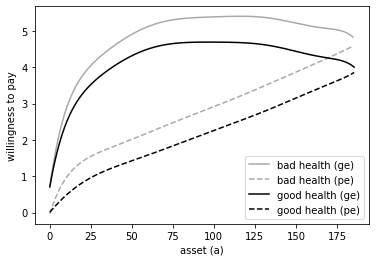

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


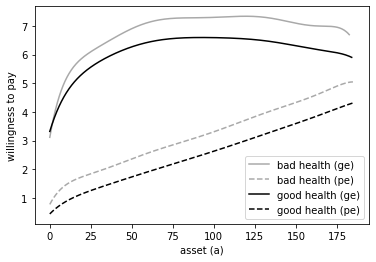

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


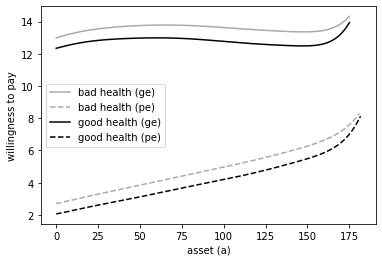

In [16]:
degpol = 8
hs = [0,1]
es = [0,4,9]
elabels = ['low','middle','high']
hlabels = ['bad health','good health']
hcolors = ['darkgray','black']
for i,e in enumerate(es):
    plt.figure()
    for h in hs:
        cond = (opts['pus_ge'].e == e) & (opts['pus_ge'].h == h)
        wtps = opts['peu_ge'].loc[cond,'wtpfl']
        wtps.index = np.arange(len(wtps))
        ws = wtps.loc[wtps.isna()==False]

        ks = gridk[ws.index.values]
        p = np.polyfit(ks, ws, deg=degpol)#4)
        w = np.poly1d(p)
        plt.plot(ks,[w(k) for k in ks],color=hcolors[h],label=hlabels[h]+' (ge)')
        
        wtps = opts['peu_pe'].loc[cond,'wtpfl']
        wtps.index = np.arange(len(wtps))
        ws = wtps.loc[wtps.isna()==False]
        ks = gridk[ws.index.values]
        p = np.polyfit(ks, ws, deg=degpol)#4)
        w = np.poly1d(p)
        plt.plot(ks,[w(k) for k in ks],'--',color=hcolors[h],label=hlabels[h]+' (pe)')
    plt.xlabel('asset (a)')
    plt.ylabel('willingness to pay')
    plt.legend() 
    plt.savefig('../figures/fig_f1_wtp_price_'+elabels[i]+'.eps')
    plt.show()

# Cost-of-Living Index

The price index is based on the follownig formula
$$
I_{LC}(a,h,e) = \frac{{\cal \hat{E}}_{US}}{{\cal E}_{EU}} = \frac{a + {\cal P} + G_{p=p_{EU}}}{a + G_{p=p_{EU}}} 
~~\Rightarrow~~ 
I_{LC}(h,e) = \sum_a \frac{a + {\cal P} + G_{p=p_{EU}}}{a + G_{p=p_{EU}}} \lambda(a)
$$
because the costs of living are 
$$
{\cal E}_{EU} = a + G_{p=p_{EU}}
$$
for an individual living in a economy where $p=p_{EU}$ and with the endovment $a + G_{p=p_{EU}}$ and 
$$
{\cal \hat{E}}_{US} = a + {\cal P} + G_{p=p_{EU}}
$$
for an individual living in a economy where $p=p_{US}$ and with the same endovment $a + G_{p=p_{EU}}$

Remark: it is necessary to control for the changes in $G$ in order to have two individuals with the same endovments. This leads to define ${\cal \hat{E}}_{US}$ which is different from the standard expenditure function
$$
{\cal \hat{E}}_{US} \neq {\cal E}_{US} = a + {\cal P} + G_{p=p_{US}}
$$


## Human Wealth Calculations

In [17]:
ge = np.zeros((ne,len(scenarios)))
for i,scn in enumerate(scenarios):
    pi = eqs[scn].inc.tprob
    ri = 1/(1+aggs.loc['r',scn])
    res   = np.eye(ne) - ri*pi
    ires   = np.linalg.inv(res)
    ge[:,i] = (1-aggs.loc['tax',scn])*aggs.loc['w',scn]*(ires@np.exp(eqs[scn].inc.pte))

## Cost of Living Calculations

In [18]:
for scn in scenarios[1:]:
    opts[scn]['ilt'] = 0.0
    opts[scn]['ge']  = 0.0

for i in opts['pus_ge'].index:   
    for j,scn in enumerate(scenarios[1:]):
        col_ref = gridk[opts['pus_ge'].loc[i,'k']] + opts[scn].loc[i,'wtpfl'] + ge[opts[scn].loc[i,'e'],1+j]
        col     = gridk[opts[scn].loc[i,'k']] + ge[opts[scn].loc[i,'e'],1+j]
        cc_ref  = gridk[opts['pus_ge'].loc[i,'k']] + opts[scn].loc[i,'wtpfl']
        cc      = gridk[opts['pus_ge'].loc[i,'k']]
        opts[scn].loc[i,'ge']      = ge[opts['pus_ge'].loc[i,'e'],0]/ge[opts[scn].loc[i,'e'],1+j]
        opts[scn].loc[i,'col']     = col
        opts[scn].loc[i,'col_ref'] = col_ref        
        opts[scn].loc[i,'ilt']     = (col_ref/col)*100

## Tables

In [19]:
es = [0,4,9]
columns = ['0','4','9','Total']
hs = [0,1]
equ = ['ge','pe']
ll = [equ,hs]
rows = list(product(*ll))
index = pd.MultiIndex.from_tuples(rows, names=['equilibrium','health'])
table_p = pd.DataFrame(index=index,columns=columns)
for q in equ:
    for j,e in enumerate(es):
        for h in hs:
            cond = (opts['peu_'+q].e == e) & (opts['peu_'+q].h == h)
            sel  = opts['peu_'+q].loc[cond,['ps','ilt']]
            sel  = sel.loc[sel['ilt'].isna()!=True,:]
            sel['ps'] = sel['ps']/sel['ps'].sum()
            sel['p']  = sel['ps']*sel['ilt']
            table_p.loc[(q,h),columns[j]] = sel['p'].sum()
    sel = opts['peu_'+q].loc[:,['ps','ilt']]
    sel = sel.loc[sel['ilt'].isna()!=True,:]
    sel['ps'] = sel['ps']/sel['ps'].sum()
    sel['p'] = sel['ps']*sel['ilt']
    table_p.loc[(q,0),columns[-1]] = sel['p'].sum()  

In [20]:
table_p

0           4           9       Total
equilibrium health                                                
ge          0       100.479095  101.975579   103.53165  102.234567
            1       100.999855  102.117013   103.31336         NaN
pe          0       100.075325  100.632447  101.240347  100.577746
            1       100.236982  100.521883  101.032383         NaN

This is Table 11. 

In [21]:
table_p.round(3).to_latex('../tables/table_11_col_index.tex')

## Willingness to Pay for a Price Change

Compiling the table

In [22]:
es = [0,4,9]
columns = ['0','4','9','Total']
hs = [0,1]
equ = ['ge','pe']
ll = [equ,hs]
rows = list(product(*ll))
index = pd.MultiIndex.from_tuples(rows, names=['equilibrium','health'])
table_w = pd.DataFrame(index=index,columns=columns)
for q in equ:
    for j,e in enumerate(es):
        for h in hs:
            cond = (opts['peu_'+q].e == e) & (opts['peu_'+q].h == h)
            sel  = opts['peu_'+q].loc[cond,['ps','wtpfl','c']]
            sel  = sel.loc[sel['wtpfl'].isna()!=True,:]
            sel['ps'] = sel['ps']/sel['ps'].sum()
            sel['Awtpfl']  = (sel['ps']*sel['wtpfl']).sum()
            sel['wtpc']    = ((sel['ps']*sel['wtpfl']).sum())/((sel['ps']*opts['pus_ge'].loc[cond,'c']).sum())
            table_w.loc[(q,h),columns[j]] = sel['wtpc'].loc[sel['wtpc'].index[0]]
    sel = opts['peu_'+q].loc[:,['ps','wtpfl','c']]
    sel = sel.loc[sel['wtpfl'].isna()!=True,:]
    sel['ps'] = sel['ps']/sel['ps'].sum()
    sel['Awtpfl']  = (sel['ps']*sel['wtpfl']).sum()
    sel['wtpc']    = ((sel['ps']*sel['wtpfl']).sum())/((sel['ps']*opts['pus_ge'].loc[:,'c']).sum())
    table_w.loc[(q,0),columns[-1]] = sel['wtpc'].loc[sel['wtpc'].index[0]]  

In [23]:
table_w

0         4         9     Total
equilibrium health                                        
ge          0       2.242532  3.120702  2.545802  2.542036
            1       2.168093  2.601782  2.347443       NaN
pe          0       0.311334  0.896056  0.824207   0.60348
            1       0.451886  0.576324  0.677176       NaN

This is Table 10

In [24]:
table_w.round(3).to_latex('../tables/table_10_wtp.tex')